In [1]:
from IPython.display import display, HTML

def show_step(title):
    display(HTML(f"""
    <div style="
        background: linear-gradient(135deg, #6a11cb, #2575fc);
        color: white;
        padding: 22px 30px;
        border-radius: 18px;
        text-align: center;
        font-family: 'Poppins', 'Segoe UI', Arial, sans-serif;
        font-size: 24px;
        font-weight: 600;
        width: 65%;
        margin: 30px auto;
        box-shadow: 0 8px 20px rgba(37, 117, 252, 0.35);
        letter-spacing: 0.7px;
        text-shadow: 0 2px 4px rgba(0,0,0,0.25);
        transition: transform 0.3s ease, box-shadow 0.3s ease;
    ">
        {title}
    </div>
    """))

In [2]:
show_step("🔹 Extract Data")

In [3]:
#Extract Data from SQL
import pandas as pd
from sqlalchemy import create_engine
import urllib

params = urllib.parse.quote_plus(
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=localhost;"
    "DATABASE=StudentDB;"
    "Trusted_Connection=yes;"
)

engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

with engine.connect() as conn:
    query = "SELECT * FROM dbo.StudentPerformance;"
    df = pd.read_sql(query, conn)
df.to_csv("StudentPerformance_from_SQL.csv", index=False, encoding="utf-8")

In [4]:
#Extrac Data From Mongo
from pymongo import MongoClient
import pandas as pd

client = MongoClient("mongodb://localhost:27017/")
db = client["StudentDB"]
collection = db["StudnetDB_Mongo"]  

data = list(collection.find())
df1 = pd.DataFrame(data)

if "_id" in df1.columns:
    df1.drop(columns=["_id"], inplace=True)
print(df1.head())
df1.to_csv("StudentPerformance_from_Mongo.csv", index=False, encoding="utf-8-sig")


   student_id             name  subject  score       date attendance
0           1     Allison Hill  Science     33 2025-08-24     Absent
1           2      Noah Rhodes  History     47 2025-02-03    Present
2           3  Angie Henderson  Science     84 2025-07-07    Present
3           4    Daniel Wagner  Science     57 2024-10-16    Present
4           5  Cristian Santos     Math     55 2025-06-16     Absent


In [5]:
#API
from flask import Flask, request, send_file, render_template
import csv, random, datetime
from faker import Faker

app = Flask(__name__)
fake = Faker('en_US')

subjects = ["Math", "Physics", "Chemistry", "Biology", "History"]

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/generate', methods=['POST'])
def generate():
    try:
        count = int(request.form['count'])
    except ValueError:
        return "Invalid count value", 400

    filename = "students_generated.csv"
    
    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["student_id","name","sub","score","date","attendance"]) 
        
        for i in range(1, count + 1):
            random_name = fake.name()
            random_date = fake.date_between(start_date='-2y', end_date='today').strftime("%Y-%m-%d")
            
            writer.writerow([
                i,
                random_name,
                random.choice(subjects),
                random.randint(0, 100),
                random_date,
                random.choice(["Present","Absent"])
            ])
            
    return send_file(filename, as_attachment=True, mimetype='text/csv')

if __name__ == '__main__':
    app.run(debug=True, use_reloader=False)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


In [ ]:
show_step("🔹 Data Integration")

In [6]:
import pandas as pd
import os
sql_file = "StudentPerformance_from_SQL.csv"
mongo_file = "StudentPerformance_from_Mongo.csv"
api_file = "students_generated.csv"

dfs = [] 

for file in [sql_file, mongo_file, api_file]:
    if os.path.exists(file):
        df = pd.read_csv(file)
        print(f" Loaded {file} with {len(df)} rows")
        dfs.append(df)
    else:
        print(f" File not found: {file}")
if dfs:
    combined_df = pd.concat(dfs, ignore_index=True)
    print(f"\n Total combined rows: {len(combined_df)}")

    combined_df.to_csv("StudentPerformance_All.csv", index=False, encoding="utf-8-sig")
    print("\n Saved combined dataset as: StudentPerformance_All.csv")
else:
    print(" No data files found to combine.")


 Loaded StudentPerformance_from_SQL.csv with 25000 rows
 Loaded StudentPerformance_from_Mongo.csv with 25000 rows
 Loaded students_generated.csv with 50000 rows

 Total combined rows: 100000

 Saved combined dataset as: StudentPerformance_All.csv


In [7]:
show_step("🟠 Transform Data")

In [8]:
import pandas as pd

df = pd.read_csv("StudentPerformance_All.csv")
print(df.shape)


(100000, 6)


In [9]:
print(df.head())


   student_id              name    subject  score        date attendance
0       25001       Eric Holmes  Geography     33  2025-06-24     Absent
1       25002      Allison Gray  Chemistry     73  2024-10-21    Present
2       25003  Teresa Torres MD     Arabic     86  2025-05-22     Absent
3       25004     James Coleman     Arabic     39  2024-11-10    Present
4       25005     Brian Aguirre    Physics     86  2024-12-05     Absent


In [10]:
import pandas as pd

#average score for each subject

df.groupby("subject")["score"].mean()

subject
Arabic       65.246457
Chemistry    54.727634
Computer     64.421628
English      54.537186
Geography    65.221192
History      64.948997
Math         54.318931
Physics      54.676544
Science      64.814935
Name: score, dtype: float64

In [11]:
# Add a new column 'status' showing 'Pass' if score >= 50, otherwise 'Fail'

df["status"] = df["score"].apply(lambda x: "Pass" if x >= 50 else "Fail")

df

,student_id,name,subject,score,date,attendance,status
0,25001,Eric Holmes,Geography,33,2025-06-24,Absent,Fail
1,25002,Allison Gray,Chemistry,73,2024-10-21,Present,Pass
2,25003,Teresa Torres MD,Arabic,86,2025-05-22,Absent,Pass
3,25004,James Coleman,Arabic,39,2024-11-10,Present,Fail
4,25005,Brian Aguirre,Physics,86,2024-12-05,Absent,Pass
...,...,...,...,...,...,...,...
99995,49996,Ibrahim Gamal,Physics,45,2025-04-22,Absent,Fail
99996,49997,Fares Adel,Chemistry,5,2024-12-30,Absent,Fail
99997,49998,Nabil Hamed,Chemistry,77,2025-02-04,Present,Pass
99998,49999,Tarek Adel,Physics,31,2023-11-17,Absent,Fail


In [12]:
# Calculate the percentage of Pass and Fail students for each subject

pass_ratio = df.groupby("subject")["status"].value_counts(normalize=True).unstack().fillna(0) * 100
pass_ratio = pass_ratio.reset_index()

pass_ratio

status,subject,Fail,Pass
0,Arabic,27.587444,72.412556
1,Chemistry,42.979990,57.020010
2,Computer,29.214491,70.785509
3,English,42.942710,57.057290
4,Geography,27.953471,72.046529
5,History,27.987479,72.012521
6,Math,43.003582,56.996418
7,Physics,42.569925,57.430075
8,Science,28.246753,71.753247


In [13]:
# Calculate attendance percentage (Present/Absent) for each subject

attendance_summary = df.groupby(["subject", "attendance"]).size().unstack(fill_value=0)

attendance_summary["Total"] = attendance_summary.sum(axis=1)

attendance_percentage = attendance_summary.div(attendance_summary["Total"], axis=0) * 100

attendance_percentage = attendance_percentage.drop(columns=["Total"], errors="ignore")


attendance_percentage.round(2)

attendance,Absent,Present
subject,,
Arabic,49.94,50.06
Chemistry,50.05,49.95
Computer,49.80,50.20
English,50.04,49.96
Geography,50.51,49.49
History,49.07,50.93
Math,49.86,50.14
Physics,50.07,49.93
Science,50.79,49.21


In [14]:
# Classify each student's score into performance levels: Low, Medium, or High

def categorize_score(score):
    if score >= 80:
        return "High"
    elif score >= 50:
        return "Medium"
    else:
        return "Low"

df["Performance_Level"] = df["score"].apply(categorize_score)
df


,student_id,name,subject,score,date,attendance,status,Performance_Level
0,25001,Eric Holmes,Geography,33,2025-06-24,Absent,Fail,Low
1,25002,Allison Gray,Chemistry,73,2024-10-21,Present,Pass,Medium
2,25003,Teresa Torres MD,Arabic,86,2025-05-22,Absent,Pass,High
3,25004,James Coleman,Arabic,39,2024-11-10,Present,Fail,Low
4,25005,Brian Aguirre,Physics,86,2024-12-05,Absent,Pass,High
...,...,...,...,...,...,...,...,...
99995,49996,Ibrahim Gamal,Physics,45,2025-04-22,Absent,Fail,Low
99996,49997,Fares Adel,Chemistry,5,2024-12-30,Absent,Fail,Low
99997,49998,Nabil Hamed,Chemistry,77,2025-02-04,Present,Pass,Medium
99998,49999,Tarek Adel,Physics,31,2023-11-17,Absent,Fail,Low


In [15]:
# Determine the most common performance level (High, Medium, Low) for each subject

top_performance_per_subject = (
    df.groupby("subject")["Performance_Level"]
      .agg(lambda x: x.value_counts().index[0])  
      .reset_index()
)

top_performance_per_subject

,subject,Performance_Level
0,Arabic,Medium
1,Chemistry,Low
2,Computer,Medium
3,English,Low
4,Geography,Medium
5,History,Medium
6,Math,Low
7,Physics,Low
8,Science,Medium


In [16]:
#Convert 'date' column to datetime format

df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["date"]


0       2025-06-24
1       2024-10-21
2       2025-05-22
3       2024-11-10
4       2024-12-05
           ...    
99995   2025-04-22
99996   2024-12-30
99997   2025-02-04
99998   2023-11-17
99999   2023-12-17
Name: date, Length: 100000, dtype: datetime64[ns]

<Axes: xlabel='date'>

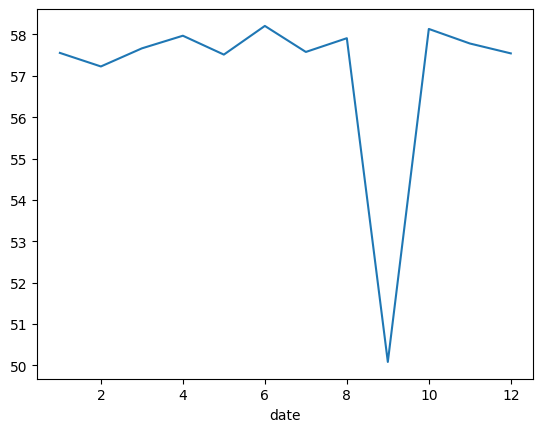

In [17]:
#average score per month as a line chart

df.groupby(df["date"].dt.month)["score"].mean().plot(kind="line")

In [18]:
# display the percentage of students who scored above 80%

total_students = len(df)
high_students = len(df[df["score"] > 80])

percentage_high = (high_students / total_students) * 100

print(f"Percentage of students who got above 80% --> {percentage_high:.2f}%")

Percentage of students who got above 80% --> 23.97%


In [19]:
# Calculate the percentage of students scoring above 80% for each subject

subject_high = df.groupby("subject").apply(
    lambda x: (len(x[x["score"] > 80]) / len(x)) * 100
)
subject_high

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15152\2267008866.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subject_high = df.groupby("subject").apply(


subject
Arabic       28.825112
Chemistry    22.457417
Computer     27.367288
English      22.566691
Geography    29.243911
History      28.153195
Math         21.846239
Physics      22.453614
Science      27.723665
dtype: float64

In [20]:
# Create a new column indicating whether each student scored above 80%

df["Top_Student"] = df["score"].apply(lambda x: "Yes" if x > 80 else "No")
df


,student_id,name,subject,score,date,attendance,status,Performance_Level,Top_Student
0,25001,Eric Holmes,Geography,33,2025-06-24,Absent,Fail,Low,No
1,25002,Allison Gray,Chemistry,73,2024-10-21,Present,Pass,Medium,No
2,25003,Teresa Torres MD,Arabic,86,2025-05-22,Absent,Pass,High,Yes
3,25004,James Coleman,Arabic,39,2024-11-10,Present,Fail,Low,No
4,25005,Brian Aguirre,Physics,86,2024-12-05,Absent,Pass,High,Yes
...,...,...,...,...,...,...,...,...,...
99995,49996,Ibrahim Gamal,Physics,45,2025-04-22,Absent,Fail,Low,No
99996,49997,Fares Adel,Chemistry,5,2024-12-30,Absent,Fail,Low,No
99997,49998,Nabil Hamed,Chemistry,77,2025-02-04,Present,Pass,Medium,No
99998,49999,Tarek Adel,Physics,31,2023-11-17,Absent,Fail,Low,No


In [21]:
show_step("🟢 Load Data")

In [ ]:
# Export the cleaned DataFrame to a CSV file 
df.to_csv("stu_performance_etl.csv", index=False)

In [ ]:
import pandas as pd
from sqlalchemy import create_engine, text
import urllib

df = pd.read_csv("stu_performance_etl.csv")
df.columns = df.columns.str.lower()


params = urllib.parse.quote_plus(
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=localhost;"
    "DATABASE=StudentDB_Transformed;"
    "Trusted_Connection=yes;"
)
engine = create_engine(f"mssql+pyodbc:///?odbc_connect={params}")


with engine.begin() as conn:
    conn.execute(text("DELETE FROM Scores"))
    conn.execute(text("DELETE FROM Subjects"))
    conn.execute(text("DELETE FROM Students"))
   


students_df = df[["student_id", "name"]].drop_duplicates(subset="student_id")
subjects_df = pd.DataFrame(df["subject"].drop_duplicates()).rename(columns={"subject": "subject_name"})
scores_df = df[
    ["student_id", "subject", "score", "date", "attendance", "status", "performance_level", "top_student"]
]

with engine.begin() as conn:
    students_df.to_sql("Students", conn, if_exists="append", index=False)
    subjects_df.to_sql("Subjects", conn, if_exists="append", index=False)
    
    subject_map = pd.read_sql("SELECT * FROM Subjects", conn)
    scores_df = scores_df.merge(subject_map, left_on="subject", right_on="subject_name", how="left")
    scores_df = scores_df.drop(columns=["subject", "subject_name"])
    
    scores_df.to_sql("Scores", conn, if_exists="append", index=False)




🧹 Old data cleared successfully!
🎯 Data loaded successfully into SQL Server!
